In [1]:
import sys
sys.path.insert(0, '../code')

import os
import sys,time
import numpy as np
import math
import cv2

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

from keras.applications.imagenet_utils import preprocess_input
from keras.preprocessing import image

from models.ssd import build_ssd
from tools.ssd_utils import BBoxUtility
from tools.yolo_utils import BoundBox


Using TensorFlow backend.


Define some useful variables

In [3]:
# Net output post-processing needs two parameters:
detection_threshold = 0.5 # Min probablity for a prediction to be considered
nms_threshold       = 0.2 # Non Maximum Suppression threshold
# IMPORTANT: the values of these two params will affect the final performance of the netwrok
#            you are allowed to find their optimal values in the validation/train sets

weights_file = "/home/master/experiments/master/Experiments/TT100K_detection/baseline_ssd/weights.hdf5"
path_to_images = "/home/master/experiments/Datasets/detection/TT100K_detection/train/"

# only for TT100K
classes     = ['i2','i4','i5','il100','il60','il80','io','ip','p10','p11','p12','p19','p23','p26','p27','p3','p5','p6','pg','ph4','ph4.5','ph5','pl100','pl120','pl20','pl30','pl40','pl5','pl50','pl60','pl70','pl80','pm20','pm30','pm55','pn','pne','po','pr40','w13','w32','w55','w57','w59','wo']
input_shape = (300,300,3)

NUM_CLASSES = len(classes)+1

Create an SSD model an load the weights

In [4]:
model = build_ssd(img_shape=input_shape,n_classes=NUM_CLASSES)
model.load_weights(weights_file)

Prepare variables to compute metrics

In [5]:
test_dir = path_to_images
imfiles = [os.path.join(test_dir,f) for f in os.listdir(test_dir) 
                                    if os.path.isfile(os.path.join(test_dir,f)) 
                                    and f.endswith('jpg')]

if len(imfiles) == 0:
    print "ERR: path_to_images do not contain any jpg file"
    quit()

Loop through images

128/128 [==============================] - 1s     
128 images predicted in 1.28005 seconds. 99.99570 fps
[]


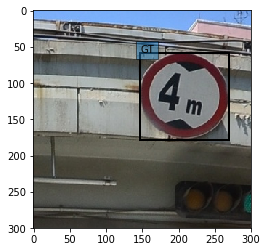

[ 0.64602697]


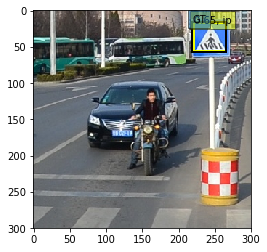

[]


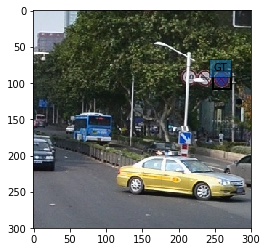

[ 0.51840168]


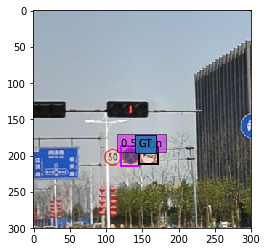

[ 0.94632864]


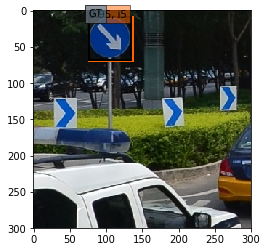

[ 0.97693038]


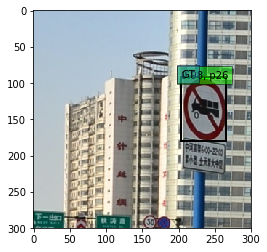

[ 0.97541875]


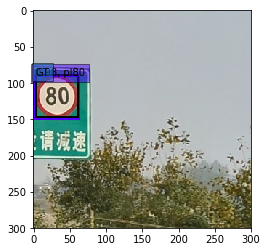

[ 0.61265308]


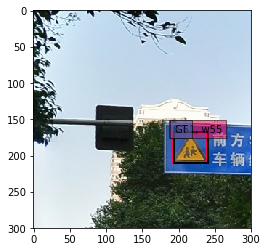

[ 0.99058902]


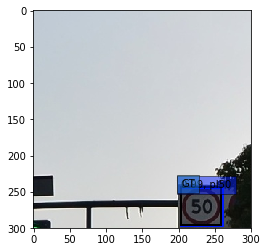

[]


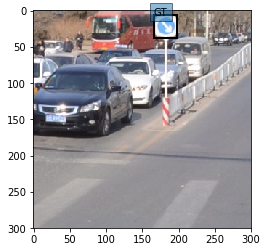

[ 0.68011576]


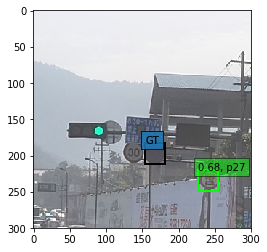

[]


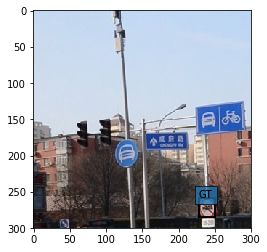

[ 0.90763974]


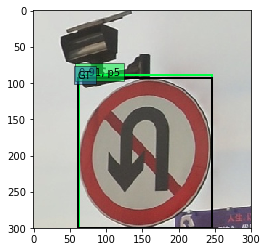

[ 0.79891074]


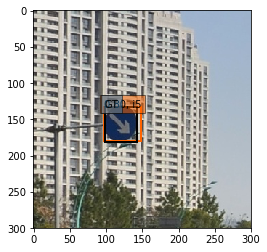

[ 0.7007851   0.58723539]


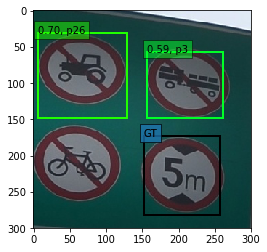

[ 0.96728009]


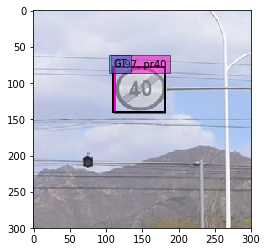

[ 0.98819983  0.97715795]


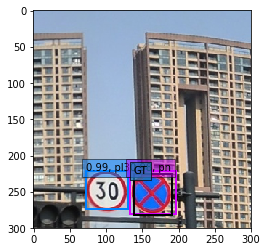

[ 0.97185677]


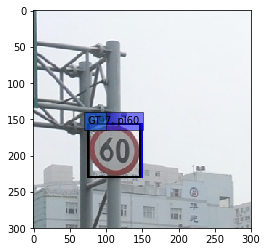

[ 0.9796862]


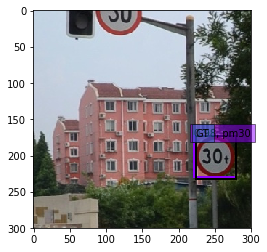

[ 0.97534251]


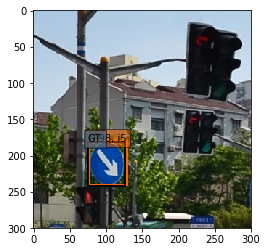

[ 0.9146353   0.90424979]


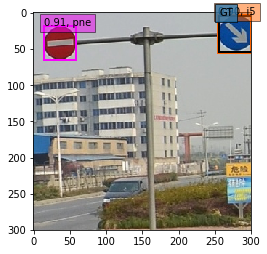

[ 0.96560305]


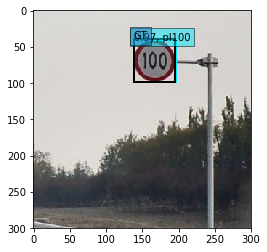

[ 0.83255577]


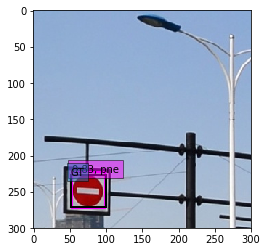

[ 0.89045966  0.85327065]


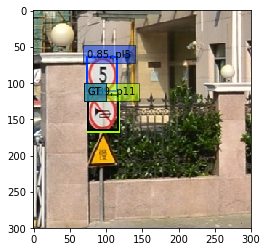

[ 0.67706072]


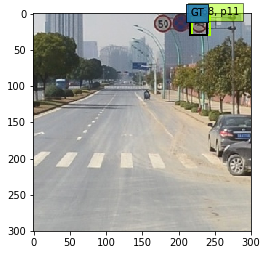

[ 0.96974808]


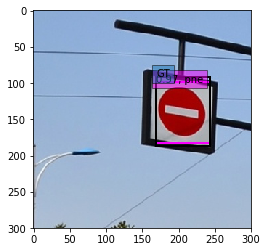

[ 0.65184468]


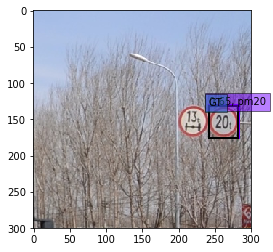

[ 0.85719413  0.8524732 ]


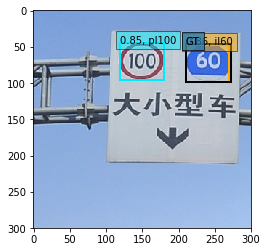

[ 0.63142443]


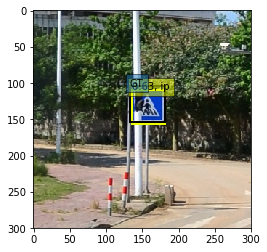

[]


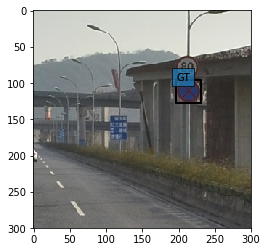

[]


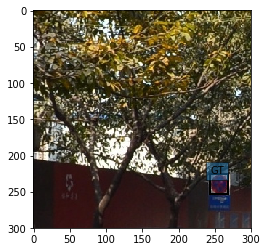

[ 0.77321541]


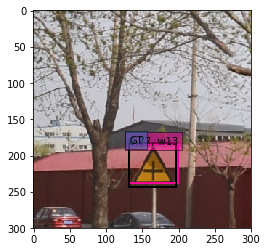

[]


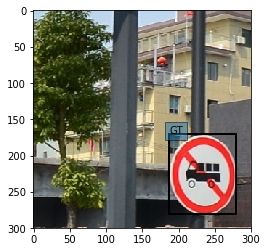

[ 0.87041366  0.81988996]


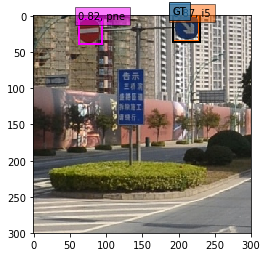

[ 0.97420835  0.96098882]


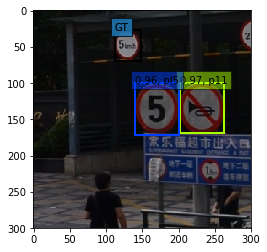

[]


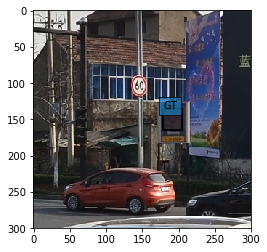

[ 0.57676113]


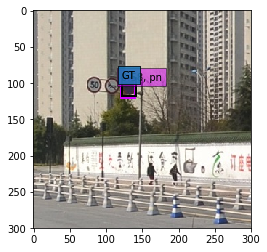

[ 0.73952729]


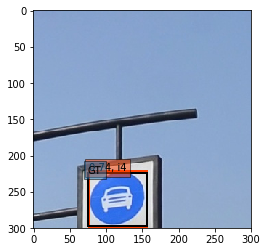

[ 0.92119682]


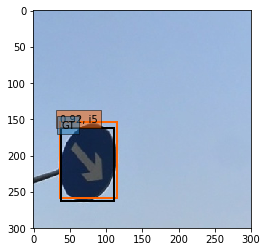

[]


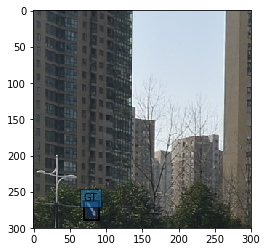

[]


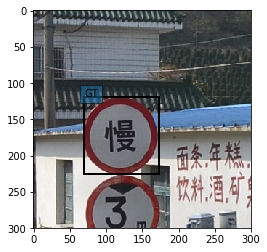

[]


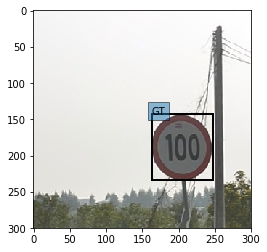

[ 0.99298757  0.99184567]


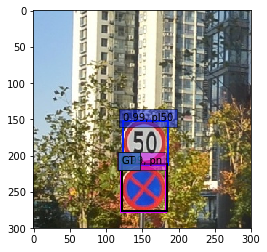

[ 0.63083601]


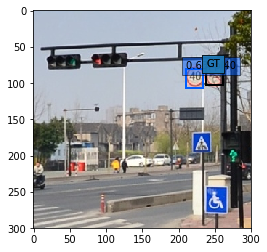

[ 0.55142349]


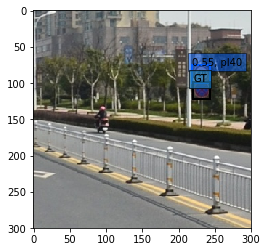

[ 0.55546415]


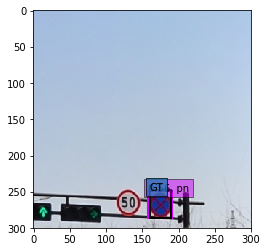

[ 0.67403454]


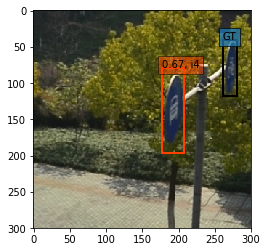

[]


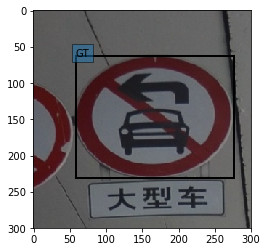

[ 0.84911418]


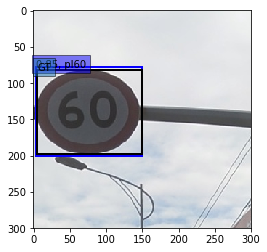

[]


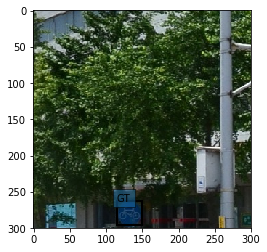

[ 0.98716402]


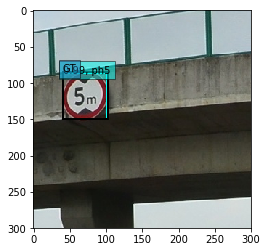

[ 0.60032314]


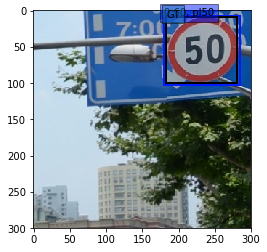

[ 0.52536458]


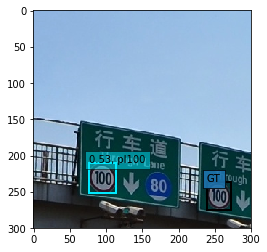

[ 0.80858183  0.60430855]


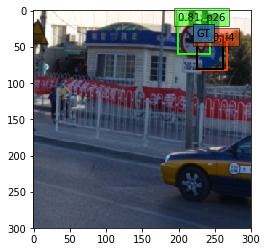

[]


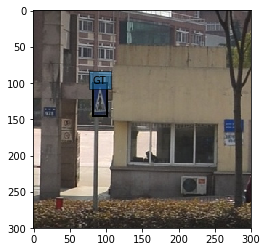

[ 0.54035723]


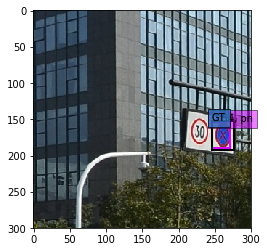

[ 0.6262424]


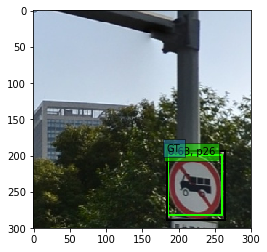

[]


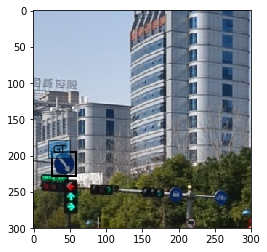

[ 0.9795928   0.9688794   0.72043002  0.56499392]


IndexError: list index out of range

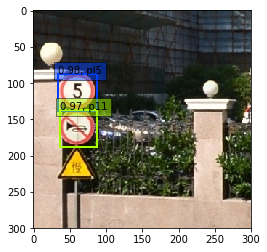

In [10]:
inputs = []
img_paths = []
chunk_size = 128 # we are going to process all image files in chunks

ok = 0.
total_true = 0.
total_pred = 0.
bbox_util = BBoxUtility(NUM_CLASSES-1, sess=True, nms_thresh=nms_threshold) # -1 because the void class is added inside

for i,img_path in enumerate(imfiles):
    img = image.load_img(img_path, target_size=(input_shape[0], input_shape[1]))
    img = image.img_to_array(img)
    img = img / 255.
    inputs.append(img.copy())
    img_paths.append(img_path)

    if len(img_paths)%chunk_size == 0 or i+1 == len(imfiles):
        inputs = np.array(inputs)
        start_time = time.time()
        net_out = model.predict(inputs, batch_size=16, verbose=1)
        print ('{} images predicted in {:.5f} seconds. {:.5f} fps').format(len(inputs),time.time() - start_time,(len(inputs)/(time.time() - start_time)))
        
        # predicted boxes
        results = bbox_util.detection_out(net_out)
        for i,img_path in enumerate(img_paths):
            boxes_true = []
            label_path = img_path.replace('jpg','txt')
            gt = np.loadtxt(label_path)
            if len(gt.shape) == 1:
                gt = gt[np.newaxis,]
            for j in range(gt.shape[0]):
                bx = BoundBox(len(classes))
                bx.probs[int(gt[j,0])] = 1.
                bx.x, bx.y, bx.w, bx.h = gt[j,1:].tolist()
                box = gt[j,:]
                bx.x = box[1] - box[3]/2
                bx.y = box[2] - box[4]/2
                bx.w = box[1] + box[3]/2
                bx.h = box[2] + box[4]/2
                boxes_true.append(bx)
            
            img = inputs[i]
            # Parse the outputs.
            det_label, det_conf, det_xmin, det_ymin, det_xmax, det_ymax = results[i][:,0], results[i][:,1], results[i][:,2], results[i][:,3], results[i][:,4], results[i][:,5]

            # Get detections with confidence higher than detection_threshold.
            top_indices = [i for i, conf in enumerate(det_conf) if conf >= detection_threshold]

            top_conf = det_conf[top_indices]
            top_label_indices = det_label[top_indices].tolist()
            top_xmin = det_xmin[top_indices]
            top_ymin = det_ymin[top_indices]
            top_xmax = det_xmax[top_indices]
            top_ymax = det_ymax[top_indices]

            colors = plt.cm.hsv(np.linspace(0, 1, len(classes))).tolist()

            plt.imshow(img)
            currentAxis = plt.gca()
            
            print(top_conf)

            for i in range(top_conf.shape[0]):
                xmin = int(round(top_xmin[i] * img.shape[1]))
                ymin = int(round(top_ymin[i] * img.shape[0]))
                xmax = int(round(top_xmax[i] * img.shape[1]))
                ymax = int(round(top_ymax[i] * img.shape[0]))
                score = top_conf[i]
                label = int(top_label_indices[i])
                label_name = classes[label - 1]
                display_txt = '{:0.2f}, {}'.format(score, label_name)
                coords = (xmin, ymin), (xmax-xmin)*2+1, (ymax-ymin)*2+1
                color = colors[label]
                currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
                currentAxis.text(xmin, ymin, display_txt, bbox={'facecolor':color, 'alpha':0.5})
                
            # display ground truth
            for i in range(len(boxes_true)):
                xmin = int(round(bx.x * img.shape[1]))
                ymin = int(round(bx.y * img.shape[0]))
                xmax = int(round(bx.w * img.shape[1]))
                ymax = int(round(bx.h * img.shape[0]))
                display_txt = 'GT'
                coords = (xmin, ymin), xmax-xmin+1, ymax-ymin+1
                currentAxis.add_patch(plt.Rectangle(*coords, fill=False, linewidth=2))
                currentAxis.text(xmin, ymin, display_txt, bbox={'alpha':0.5})

            plt.show()
            
        break
        inputs = []
        img_paths = []